In [1]:
import pandas as pd
import numpy as np, warnings
from pathlib import Path
import os
import sys
# import sweetviz as sv
from importlib import reload
import matplotlib.pyplot as plt
import seaborn as sns
import timeshap as ts
from timeshap import __version__
__version__

np.warnings = warnings

ROOT_DIR = Path('..')
sys.path.append(os.path.abspath(os.path.join('../Kha Huynh/Data cleansing')))
import DataLoader as DataLoader
reload(DataLoader)

dataLoader = DataLoader.DataLoader(ROOT_DIR)

import model_evaluation as me
reload(me)

<module 'model_evaluation' from '/home/labadmin/work/data-science-capstone-project/Kha Huynh/Data cleansing/model_evaluation.py'>

In [2]:
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_validate, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.feature_selection import SelectFromModel

# model comparison
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier,AdaBoostClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
# from xgboost import XGBClassifier

# evaluation metrics
from sklearn.metrics import cohen_kappa_score,classification_report
from sklearn.metrics import mean_squared_error, confusion_matrix, roc_auc_score, precision_score, recall_score, f1_score, auc, make_scorer
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_curve, balanced_accuracy_score
from sklearn.metrics import PrecisionRecallDisplay
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import balanced_accuracy_score
from keras.utils import to_categorical

import tensorflow as tf

2023-10-21 16:41:22.172832: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-21 16:41:22.199172: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-21 16:41:22.384414: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-21 16:41:22.385541: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-21 16:41:23.170683: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

# Load Data

In [3]:
df_desc_icd, df_desc_labitems, df_desc_items = dataLoader.load_descriptions()
df_diagnoses_icd = dataLoader.load_diagnoses_icd(df_desc_icd)
df_demographic = dataLoader.load_demographic(df_diagnoses_icd)
df_demographic = dataLoader.demographic_clean_AGE(df_demographic)
df_labevents = dataLoader.load_labevents(df_demographic)
# df_labevents = dataLoader.labevents_compute_TIME(df_labevents, df_demographic)

Removed 8210 admissions with AGE < 18


# Dataset Extraction

In [4]:
hours_list = [0, 1, 2, 3, 4, 5, 6, 7, 8]
top_n_features = [20]
dfs_dict = {}

The code below extract data by top n features and time t and save them into the folder. To save time, the files are uploaded and will be loaded for training the model

In [9]:
for top_n in top_n_features:
  dfs_dict[f'top{top_n}'] = {}
  for hour in hours_list:
    feature_filename=ROOT_DIR / 'data/potential_events.csv'
    output_filename = ROOT_DIR / f'data/Model input data/t{hour}_top{top_n}_sequence.csv'
    try:
      extracted_df = pd.read_csv(output_filename)
    except:
      extracted_df = dataLoader.create_train_data_sequence_new(df_labevents, df_demographic, df_desc_labitems, hours=hour, feature_no=top_n, output_filename = output_filename)
    extracted_df['CHARTTIME'] = pd.to_datetime(extracted_df['CHARTTIME'], format='%Y-%m-%d %H:%M:%S')
    dfs_dict[f'top{top_n}'][f't{hour}'] = extracted_df

# Data Processing

In [12]:
import missingno as msno
import matplotlib.pyplot as plt

def visualise_missing_data(df):
    """
    Convert non-standard missing values (-999) to NaN and visualize the missing data using missingno,
    without altering the original DataFrame.

    Parameters:
        df (pd.DataFrame): The DataFrame containing the dataset.

    Returns:
        None
    """

    # Create a copy of the DataFrame to avoid changing the original
    df_copy = df.copy()

    # Replace -999 with NaN in the copy
    df_copy.replace(-999, np.nan, inplace=True)

    plt.figure(figsize=(15, 7)) 

    # Create a matrix plot for missing values
    msno.matrix(df_copy)
    plt.show()

    # Create a bar plot for missing values
    msno.bar(df_copy)
    plt.show()

    # Create a heatmap for missing values
    msno.heatmap(df_copy)
    plt.show()

visualise_missing_data(dfs_dict_without_missing['top20']['t3'])

ModuleNotFoundError: No module named 'missingno'

In [3]:
# t0_df = pd.read_csv(df_final)
path_df = ROOT_DIR / 'data/Model input data/t4_nan.csv'
df_data = pd.read_csv(path_df)# t0_df

admission = df_data[['SUBJECT_ID', 'HADM_ID', 'IS_SEPSIS']].drop_duplicates(["SUBJECT_ID", "HADM_ID"])

def df_split(X, Y, test_size):
    x_train, x_test, y_train, y_test = train_test_split(
        X,  # dropping the target column for X values
        Y,
        test_size=test_size,  # this means 20% test set
        stratify=Y,  # stratify by the target variable
        random_state=42  # to ensure reproducibility
        )
    return x_train, x_test, y_train, y_test

def create_data_df(data_df):
    x_train_df = df_data.merge(data_df[['SUBJECT_ID', 'HADM_ID']])
    x_train_df['count'] = x_train_df.groupby(['SUBJECT_ID', 'HADM_ID'])['HADM_ID'].transform('count')
    x_train_count = x_train_df.drop_duplicates(['SUBJECT_ID', 'HADM_ID'])['count']
    y_train_df = x_train_df.drop_duplicates(['SUBJECT_ID', 'HADM_ID'])['IS_SEPSIS']
    return x_train_df, x_train_count, y_train_df

x_train_df, x_test_df, y_train_df, _ = df_split(admission.drop('IS_SEPSIS', axis=1),  # dropping the target column for X values
                                                admission['IS_SEPSIS'],
                                                test_size=0.2,
                                                )

x_train_df, x_val_df, _, _ = df_split(x_train_df,  # dropping the target column for X values
                                        y_train_df,
                                        test_size=0.15,
                                        )

x_train_df, x_train_count, y_train_df = create_data_df(x_train_df)
x_test_df, x_test_count, y_test_df = create_data_df(x_test_df)
x_val_df, x_val_count, y_val_df = create_data_df(x_val_df)

In [4]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='median', missing_values=np.nan)

train_gendernum = x_train_df.GENDER_NUM.values #take out the column doesn't need to scale
test_gendernum = x_test_df.GENDER_NUM.values
val_gendernum = x_val_df.GENDER_NUM.values

# impute X
x_train = imputer.fit_transform(x_train_df.drop(["SUBJECT_ID", "HADM_ID", 'IS_SEPSIS', 'CHARTTIME', 'count', 'GENDER_NUM'], axis=1))
x_test = imputer.transform(x_test_df.drop(["SUBJECT_ID", "HADM_ID", 'IS_SEPSIS', 'CHARTTIME', 'count', 'GENDER_NUM'], axis=1))
x_val = imputer.transform(x_val_df.drop(["SUBJECT_ID", "HADM_ID", 'IS_SEPSIS', 'CHARTTIME', 'count', 'GENDER_NUM'], axis=1))

In [5]:
# Feature scaling - Standardisation
scaler = StandardScaler()

x_train = scaler.fit_transform(x_train) #scale X
x_test = scaler.transform(x_test)
x_val = scaler.transform(x_val)

x_train = np.column_stack((x_train, train_gendernum)) #merge the columns doesn't need to scale back to X
x_test = np.column_stack((x_test, test_gendernum))
x_val = np.column_stack((x_val, val_gendernum))

In [6]:
def ts_to_secs(X, X_count, Y):
    secs_data = tf.RaggedTensor.from_row_lengths(X, X_count)
    mask = tf.math.is_finite(secs_data.values)
    mask = tf.RaggedTensor.from_row_lengths(mask, X_count)

    # act_secs_labels = Y.values
    # act_secs_labels = np.array(act_secs_labels)
    act_secs_labels = to_categorical(Y)
    return secs_data, act_secs_labels, mask

In [7]:
def data_preparation():
  train_data, act_train = ts_to_secs(x_train, x_train_count, y_train_df)
  test_data, act_test = ts_to_secs(x_test, x_test_count, y_test_df)
  val_data, act_val = ts_to_secs(x_val, x_val_count, y_val_df)

  # Here we add an extra dimension to the datasets just to be ready for using with Convolution2D
  print("[INFO] -- Shape of Training Sections:")
  print(train_data.bounding_shape())
  print("[INFO] -- Shape of Test Sections:")
  print(test_data.bounding_shape())
  print("[INFO] -- Shape of Validation Sections:")
  print(val_data.bounding_shape())

  return train_data, act_train, test_data, act_test, val_data, act_val

In [8]:
x_train, y_train, x_test, y_test, x_val, y_val = data_preparation()

[INFO] -- Shape of Training Sections:
tf.Tensor([31426    13    43], shape=(3,), dtype=int64)
[INFO] -- Shape of Test Sections:
tf.Tensor([9244   13   43], shape=(3,), dtype=int64)
[INFO] -- Shape of Validation Sections:
tf.Tensor([5546   10   43], shape=(3,), dtype=int64)


# Model Definition

In [9]:
import model_evaluation as me
reload(me)

me.get_class_weights(y_train_df)

sample_weights = me.compute_sample_weights(y_train[:,1].astype(int))
# sample_weights = compute_sample_weights(y_train.astype(int))

sample_weights_test = me.compute_sample_weights(y_test[:,1].astype(int))
# sample_weights_test = compute_sample_weights(y_test.astype(int))

In [10]:
import keras

METRICS = [
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.AUC(name='auc'),
]

m_hist = []

In [11]:
from keras.layers import Dense, Activation, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import LSTM, Input, GRU, LeakyReLU
from keras.models import Sequential, Model
from sklearn.model_selection import  train_test_split
import time
import keras
import numpy as np

from keras.models import Sequential
def LSTM_model():
    feat_no = x_train[0][0].shape[0]
    d = 0.25
    model=Sequential()
    model.add(Input(shape=[None, feat_no], dtype=tf.float32, ragged=True))
    model.add(LSTM(128, return_sequences=True))
    model.add(Dropout(d))
    model.add(LSTM(64))
    model.add(Dropout(d))
    model.add(Dense(25, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='softmax'))

    return model

# Learning rates

In [12]:
from keras.optimizers import schedules
from keras.callbacks import LearningRateScheduler
import math

init_lr = 0.001
def scheduler(epoch):
  return init_lr * math.pow(0.6, math.floor(epoch / 5))    
lr_schedulers = [LearningRateScheduler(scheduler)]

def scheduler(epoch):
  return init_lr * 1 / (1 + 0.6 * epoch)  
lr_schedulers.append(LearningRateScheduler(scheduler))

def scheduler(epoch):
  return init_lr * tf.math.exp(-0.1 * epoch)
lr_schedulers.append(LearningRateScheduler(scheduler))

def scheduler(epoch):
  if epoch <= 10:
    return init_lr * tf.math.exp(-0.1 * epoch)
  else:
    return init_lr * 1 / (1 + 0.6 * epoch)
lr_schedulers.append(LearningRateScheduler(scheduler))

m_hist = []

In [13]:
for i, lr_scheduler in enumerate(lr_schedulers):
  print(f"----------------Start learning rate {i}---------------------")
  model = LSTM_model()
  model.summary()
  model.compile(optimizer=keras.optimizers.Adam(learning_rate=init_lr), loss='binary_crossentropy', metrics = METRICS)

  checkpointer = ModelCheckpoint(filepath = f'weights_best_lr_{i}.hdf5', save_best_only = True, monitor='val_accuracy', mode='max')
  # early_stop = keras.callbacks.EarlyStopping(monitor = 'val_accuracy', mode = 'max', patience=5, restore_best_weights=True)
  # callbacks_list = [lr_scheduler, early_stop, checkpointer]
  callbacks_list = [lr_scheduler, checkpointer]
  m = model.fit(x_train,y_train,
                sample_weight=sample_weights,
                # class_weight=me.get_class_weights(y_train_df),
                epochs=40, batch_size=64, verbose=1,
                validation_data=(x_val, y_val),
                callbacks=callbacks_list)
  m_hist.append(m)

----------------Start learning rate 0---------------------
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         88064     
                                                                 
 dropout (Dropout)           (None, None, 128)         0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 25)                1625      
                                                                 
 dropout_2 (Dropout)         (None, 25)                0         
                                                               

d:\Kha\UWA\CITS5553\sepsis_prediction\data-science-capstone-project\.venv\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


492/492 [==============================] - 7s 13ms/step - loss: 0.5204 - accuracy: 0.7536 - auc: 0.8285 - val_loss: 0.4907 - val_accuracy: 0.7586 - val_auc: 0.8438 - lr: 0.0010
Epoch 3/40
492/492 [==============================] - 8s 16ms/step - loss: 0.5010 - accuracy: 0.7580 - auc: 0.8398 - val_loss: 0.4617 - val_accuracy: 0.7811 - val_auc: 0.8645 - lr: 0.0010
Epoch 4/40
492/492 [==============================] - 8s 17ms/step - loss: 0.4913 - accuracy: 0.7566 - auc: 0.8449 - val_loss: 0.5014 - val_accuracy: 0.7514 - val_auc: 0.8370 - lr: 0.0010
Epoch 5/40
492/492 [==============================] - 8s 15ms/step - loss: 0.4802 - accuracy: 0.7604 - auc: 0.8493 - val_loss: 0.4927 - val_accuracy: 0.7526 - val_auc: 0.8398 - lr: 0.0010
Epoch 6/40
492/492 [==============================] - 8s 16ms/step - loss: 0.4608 - accuracy: 0.7759 - auc: 0.8625 - val_loss: 0.4958 - val_accuracy: 0.7420 - val_auc: 0.8370 - lr: 6.0000e-04
Epoch 7/40
492/492 [==============================] - 8s 16ms/step 

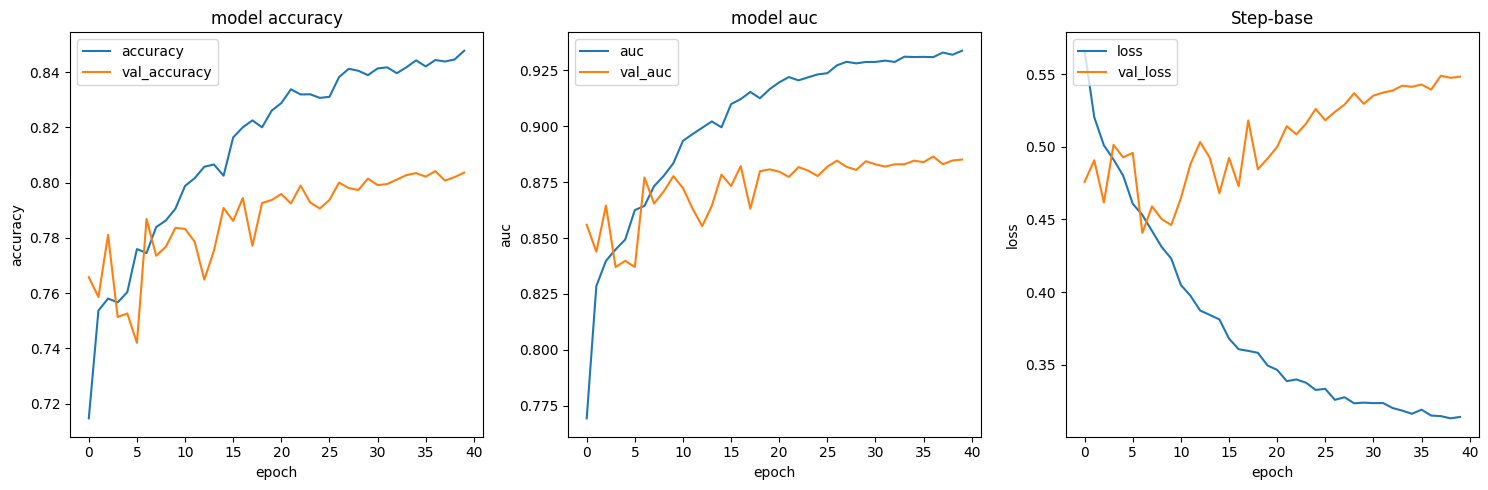

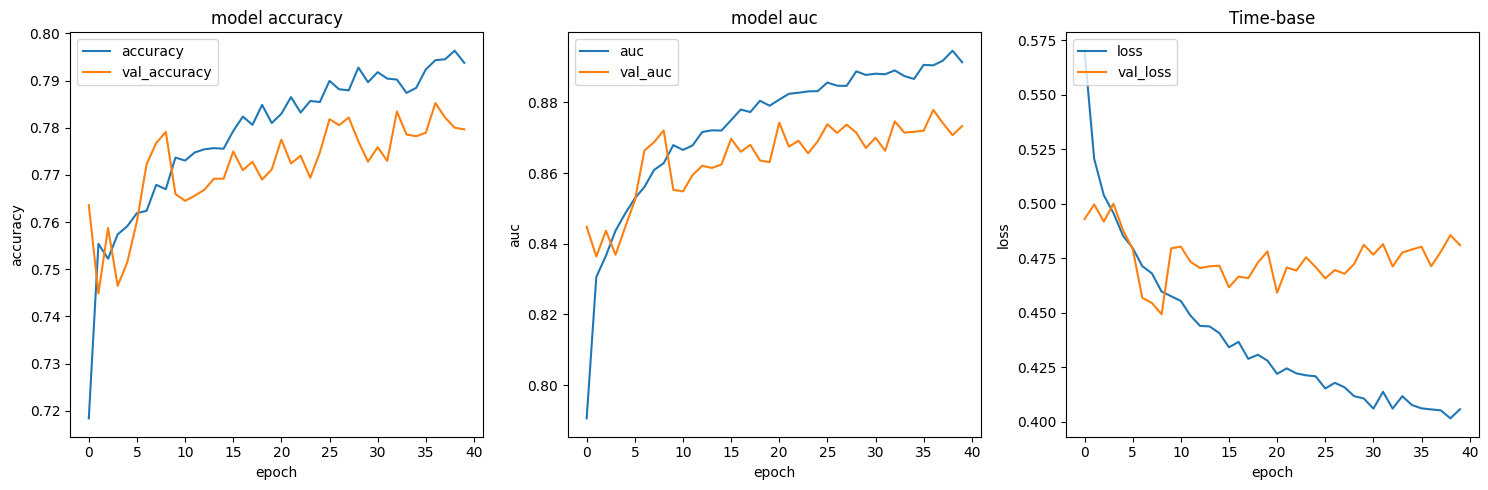

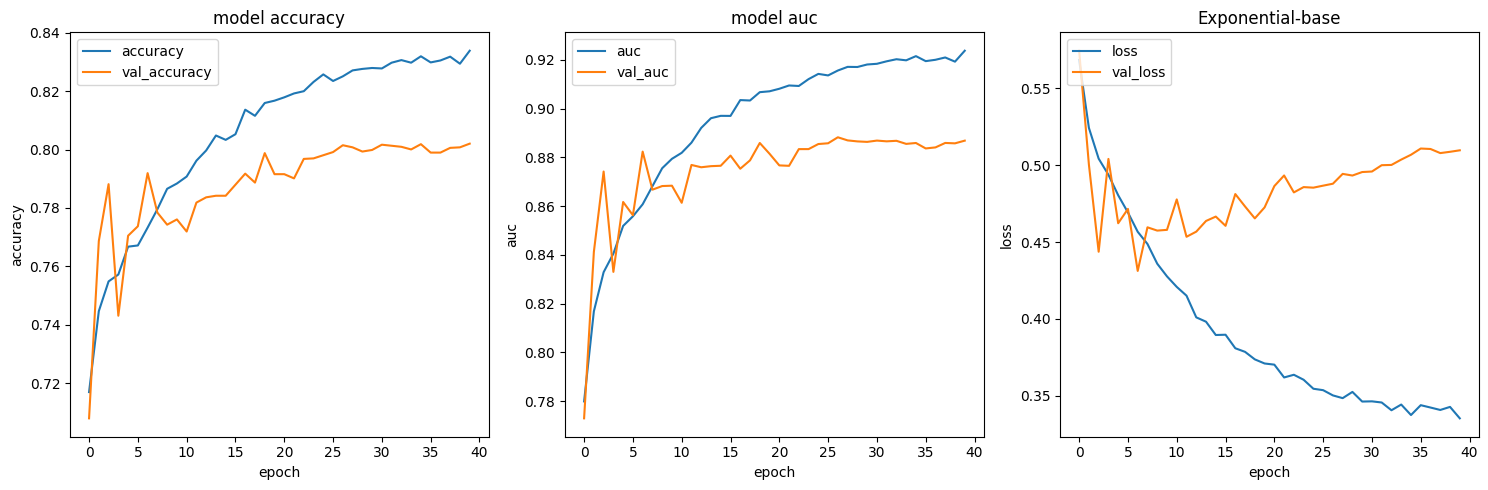

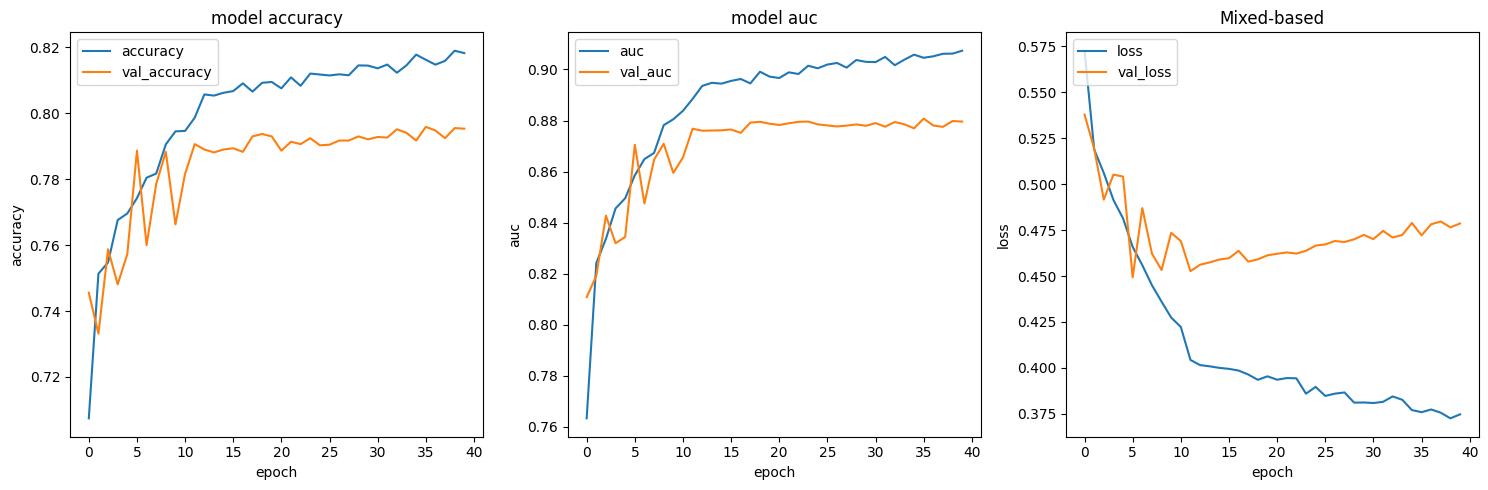

In [48]:
import matplotlib.pyplot as plt

lr_name = ['Step-base', 'Time-base', 'Exponential-base', 'Mixed-based']
for i, _ in enumerate(lr_name):
  # Create a figure with two subplots side by side
  fig, (plt1, plt2, plt3) = plt.subplots(1, 3, figsize=(15, 5))

  # plt.plot(m.history['loss'])
  plt1.plot(m_hist[i].history['accuracy'])
  plt1.plot(m_hist[i].history['val_accuracy'])
  plt1.set_title('model accuracy')
  plt1.set_ylabel('accuracy')
  plt1.set_xlabel('epoch')
  plt1.legend(['accuracy', 'val_accuracy'], loc='upper left')

  # plt.plot(m.history['loss'])
  plt2.plot(m_hist[i].history['auc'])
  plt2.plot(m_hist[i].history['val_auc'])
  plt2.set_title('model auc')
  plt2.set_ylabel('auc')
  plt2.set_xlabel('epoch')
  plt2.legend(['auc', 'val_auc'], loc='upper left')

  # plt.plot(m.history['loss'])
  plt3.plot(m_hist[i].history['loss'])
  plt3.plot(m_hist[i].history['val_loss'])
  plt3.set_title('model loss')
  plt3.set_ylabel('loss')
  plt3.set_xlabel('epoch')
  plt3.legend(['loss', 'val_loss'], loc='upper left')

  plt.title(lr_name[i])
  plt.tight_layout()
  plt.show()

# Learning rates

In [32]:
# step decay
import math
a = [init_lr]
for i in range(0, 40):
  lr = init_lr * math.pow(0.6, math.floor(i/5))
  a.append(lr)

In [33]:
# time-based decay
decay = 0.6
b = [init_lr]
for i in range(0, 40):
  lr = init_lr * 1 / (1 + decay * i)
  b.append(lr)


In [34]:
# exponential decay
c = [init_lr]
for i in range(0, 40):
  lr = init_lr * tf.math.exp(-0.1 * i)
  c.append(lr)

In [36]:
# exponential decay
d = [init_lr]
for i in range(0, 40):
  if i <= 10:
    lr = init_lr * tf.math.exp(-0.1 * i)
  else:
    lr = init_lr * 1 / (1 + decay * i)
  d.append(lr)

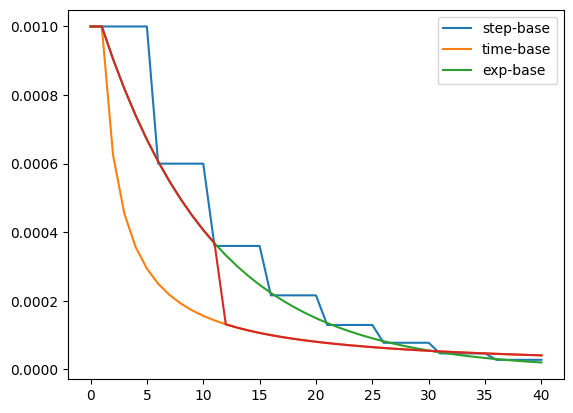

In [51]:
plt.plot(a)
plt.plot(b)
plt.plot(c)
plt.legend(['step-base', 'time-base', 'exp-base'])
plt.plot(d)
# plt.plot(e)

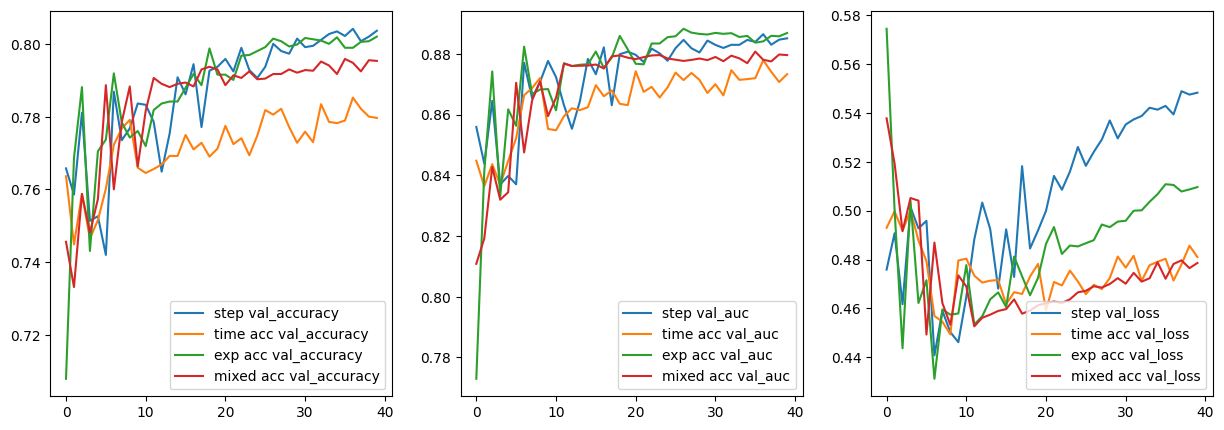

In [50]:
fig, (plt1, plt2, plt3) = plt.subplots(1, 3, figsize=(15, 5))
plts = [plt1, plt2, plt3]

chart_types = ['val_accuracy', 'val_auc', 'val_loss']

for i, chart_type in enumerate(chart_types):
  k = 0
  plts[i].plot(m_hist[k].history[chart_type])
  plts[i].plot(m_hist[k+1].history[chart_type])
  plts[i].plot(m_hist[k+2].history[chart_type])
  plts[i].plot(m_hist[k+3].history[chart_type])
  plts[i].legend([f"step {chart_type}", f"time acc {chart_type}", f"exp acc {chart_type}", f"mixed acc {chart_type}"], loc="lower right")

Inference:
Inference:
Inference:
Inference:
289/289 [==============================] - 1s 3ms/step


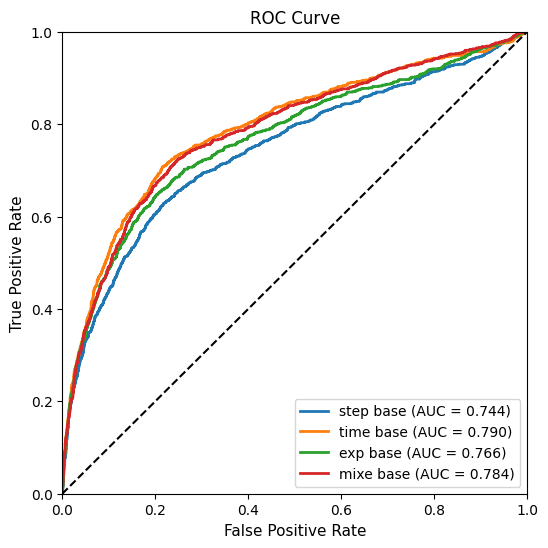

,Model,Balanced acc Train,Balanced acc Test,Precision Train,Precision Test,Recall Train,Recall Test,F1 Train,F1 Test
0,step base,0.882319,0.700961,0.426715,0.279788,0.912478,0.582915,0.581496,0.378096
1,time base,0.830618,0.743953,0.341985,0.283740,0.861029,0.701508,0.489535,0.404052
2,exp base,0.866575,0.717928,0.398606,0.285649,0.896215,0.624121,0.551793,0.391922
3,mixe base,0.845909,0.733932,0.369789,0.291206,0.870787,0.662312,0.519126,0.404543


In [64]:
from keras.models import load_model
reload(me)

trained_models = {}
model_names = ['step base', 'time base', 'exp base', 'mixe base']
for i, m in enumerate(model_names):
  print("Inference:")
  model = load_model(f"weights_best_lr_{i}.hdf5")
  model.optimizer.lr.numpy()
  trained_models[m] = model

me.plot_combined_roc_curves(trained_models, x_train, y_train, x_test, y_test)
# me.print_results(model, x_train, y_train, x_test, y_test)